In [33]:
import sqlite3
import numpy as np
import pandas as pd
from lsst.afw.table import BaseCatalog

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score, f1_score

In [2]:
db = f'/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)


supernova_mag = (20, 23)
supernova = pd.read_sql_query(f"SELECT * FROM fake_src WHERE host_mag = '20_21' and fake_mag in {supernova_mag}", conn)
artifact = pd.read_sql_query(f"SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)

supernova.drop(columns=['visit', 'detector', 'filter', 'fake_mag', 'host_mag', 'patch', 'injected_x', 'injected_y', 'injected_instFlux'], inplace=True)
supernova = supernova[supernova.matched_status.astype(bool)].reset_index(drop=True)
supernova.drop(columns=['index', 'matched_status'], inplace=True)
artifact.drop(columns=['index', 'visit', 'detector', 'filter', 'fake_mag', 'host_mag', 'patch'], inplace=True)

supernova['label'] = 1
artifact['label'] = 0

In [3]:
len(supernova.columns), len(artifact.columns)

(271, 271)

In [4]:
len(supernova), len(artifact)

(2187, 2446)

In [8]:
# get table schema and all flags
t = BaseCatalog.readFits('/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'
                         '/patch_0to6/diff/al_default_v23/00_20_21_1013665_79_i/diff_20/schema/deepDiff_diaSrc.fits')
t_astropy = t.asAstropy()
schema = t.schema
def get_flag_description(flag, schema):
    print(schema.extract(f"{flag}")[f'{flag}'].getField().getDoc())

In [9]:
flag =  'base_SdssShape_instFlux'
get_flag_description(flag, schema)

elliptical Gaussian adaptive moments


In [10]:
# artifact[flag]

In [11]:
selected_cols = ['flags_negative', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge',
                 'base_NaiveCentroid_flag_resetToPeak', 'base_PeakCentroid_flag', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge',
                 'base_SdssCentroid_flag_noSecondDerivative', 'base_SdssCentroid_flag_almostNoSecondDerivative', 'base_SdssCentroid_flag_notAtMaximum',
                 'base_SdssCentroid_flag_resetToPeak', 'base_SdssCentroid_flag_badError', 'ip_diffim_NaiveDipoleCentroid_flag', 'ip_diffim_NaiveDipoleCentroid_pos_flag',
                 'ip_diffim_NaiveDipoleCentroid_neg_flag',  

                 'base_SdssShape_instFlux', 'base_SdssShape_instFluxErr', 'base_SdssShape_psf_xx', 
                 'base_SdssShape_psf_yy', 'base_SdssShape_psf_xy', 'base_SdssShape_instFlux_xx_Cov',
                 'base_SdssShape_instFlux_yy_Cov', 'base_SdssShape_instFlux_xy_Cov', 'base_SdssShape_flag', 
                 'base_SdssShape_flag_unweightedBad', 'base_SdssShape_flag_unweighted', 'base_SdssShape_flag_shift',
                 'base_SdssShape_flag_maxIter', 'base_SdssShape_flag_psf',
                 
                 'base_CircularApertureFlux_3_0_instFlux', 'base_CircularApertureFlux_3_0_instFluxErr', 'base_CircularApertureFlux_3_0_flag',
                 'base_CircularApertureFlux_3_0_flag_apertureTruncated', 'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated', 'base_CircularApertureFlux_4_5_instFlux',
                 'base_CircularApertureFlux_4_5_instFluxErr', 'base_CircularApertureFlux_4_5_flag', 'base_CircularApertureFlux_4_5_flag_apertureTruncated',
                 'base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated', 'base_CircularApertureFlux_6_0_instFlux', 'base_CircularApertureFlux_6_0_instFluxErr',
                 'base_CircularApertureFlux_6_0_flag', 'base_CircularApertureFlux_6_0_flag_apertureTruncated', 'base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated',
                 'base_CircularApertureFlux_9_0_instFlux', 'base_CircularApertureFlux_9_0_instFluxErr', 'base_CircularApertureFlux_9_0_flag',
                 'base_CircularApertureFlux_9_0_flag_apertureTruncated', 'base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated',
                 'base_CircularApertureFlux_12_0_instFlux', 'base_CircularApertureFlux_12_0_instFluxErr', 'base_CircularApertureFlux_12_0_flag',
                 'base_CircularApertureFlux_12_0_flag_apertureTruncated', 'base_CircularApertureFlux_17_0_instFlux',
                 'base_CircularApertureFlux_17_0_instFluxErr', 'base_CircularApertureFlux_17_0_flag', 'base_CircularApertureFlux_17_0_flag_apertureTruncated',
                 'base_CircularApertureFlux_25_0_instFlux', 'base_CircularApertureFlux_25_0_instFluxErr', 'base_CircularApertureFlux_25_0_flag',
                 'base_CircularApertureFlux_25_0_flag_apertureTruncated', 'base_CircularApertureFlux_35_0_instFlux', 'base_CircularApertureFlux_35_0_instFluxErr',
                 'base_CircularApertureFlux_35_0_flag', 'base_CircularApertureFlux_35_0_flag_apertureTruncated', 'base_CircularApertureFlux_50_0_instFlux',
                 'base_CircularApertureFlux_50_0_instFluxErr', 'base_CircularApertureFlux_50_0_flag', 'base_CircularApertureFlux_50_0_flag_apertureTruncated',
                 'base_CircularApertureFlux_70_0_instFlux', 'base_CircularApertureFlux_70_0_instFluxErr', 'base_CircularApertureFlux_70_0_flag',
                 'base_CircularApertureFlux_70_0_flag_apertureTruncated', 
                 
                 'base_GaussianFlux_instFlux', 'base_GaussianFlux_instFluxErr',
'base_GaussianFlux_flag',

'base_PeakLikelihoodFlux_instFlux',
'base_PeakLikelihoodFlux_instFluxErr',
'base_PeakLikelihoodFlux_flag',
'base_PixelFlags_flag',
'base_PixelFlags_flag_offimage',
'base_PixelFlags_flag_edge',
'base_PixelFlags_flag_interpolated',
'base_PixelFlags_flag_saturated',
'base_PixelFlags_flag_cr',
'base_PixelFlags_flag_bad',
'base_PixelFlags_flag_suspect',
'base_PixelFlags_flag_interpolatedCenter',
'base_PixelFlags_flag_saturatedCenter',
'base_PixelFlags_flag_crCenter',
'base_PixelFlags_flag_suspectCenter',
'base_PsfFlux_instFlux',

'base_PsfFlux_instFluxErr',

'base_PsfFlux_area',

'base_PsfFlux_chi2',

'base_PsfFlux_npixels',

'base_PsfFlux_flag',

'base_PsfFlux_flag_noGoodPixels',

'base_PsfFlux_flag_edge',

'ip_diffim_NaiveDipoleFlux_flag',
'ip_diffim_NaiveDipoleFlux_pos_flag',
'ip_diffim_NaiveDipoleFlux_neg_flag',
'ip_diffim_NaiveDipoleFlux_pos_instFlux',
'ip_diffim_NaiveDipoleFlux_pos_instFluxErr',
'ip_diffim_NaiveDipoleFlux_neg_instFlux',
'ip_diffim_NaiveDipoleFlux_neg_instFluxErr',
'ip_diffim_NaiveDipoleFlux_npos',
'ip_diffim_NaiveDipoleFlux_nneg',
'ip_diffim_PsfDipoleFlux_flag',
'ip_diffim_PsfDipoleFlux_pos_flag',
'ip_diffim_PsfDipoleFlux_neg_flag',
'ip_diffim_PsfDipoleFlux_pos_instFlux',
'ip_diffim_PsfDipoleFlux_pos_instFluxErr',
'ip_diffim_PsfDipoleFlux_neg_instFlux',
'ip_diffim_PsfDipoleFlux_neg_instFluxErr',
'ip_diffim_PsfDipoleFlux_chi2dof',
'ip_diffim_PsfDipoleFlux_pos_centroid_x',
'ip_diffim_PsfDipoleFlux_pos_centroid_y',
'ip_diffim_PsfDipoleFlux_pos_centroid_xErr',
'ip_diffim_PsfDipoleFlux_pos_centroid_yErr',
'ip_diffim_PsfDipoleFlux_neg_centroid_x',
'ip_diffim_PsfDipoleFlux_neg_centroid_y',
'ip_diffim_PsfDipoleFlux_neg_centroid_xErr',
'ip_diffim_PsfDipoleFlux_neg_centroid_yErr',
'ip_diffim_PsfDipoleFlux_centroid_x',
'ip_diffim_PsfDipoleFlux_centroid_y',
'ip_diffim_PsfDipoleFlux_centroid_xErr',
'ip_diffim_PsfDipoleFlux_centroid_yErr',
'ip_diffim_ClassificationDipole_value',
'ip_diffim_ClassificationDipole_flag',
'ip_diffim_DipoleFit_pos_instFlux',
'ip_diffim_DipoleFit_pos_instFluxErr',
'ip_diffim_DipoleFit_pos_centroid_x',
'ip_diffim_DipoleFit_pos_centroid_y',
'ip_diffim_DipoleFit_neg_instFlux',
'ip_diffim_DipoleFit_neg_instFluxErr',
'ip_diffim_DipoleFit_neg_centroid_x',
'ip_diffim_DipoleFit_neg_centroid_y',
'ip_diffim_DipoleFit_centroid_x',
'ip_diffim_DipoleFit_centroid_y',
'ip_diffim_DipoleFit_instFlux',
'ip_diffim_DipoleFit_orientation',
'ip_diffim_DipoleFit_separation',
'ip_diffim_DipoleFit_chi2dof',
'ip_diffim_DipoleFit_signalToNoise',
'ip_diffim_DipoleFit_flag_classification',
'ip_diffim_DipoleFit_flag_classificationAttempted',
'ip_diffim_DipoleFit_flag',
'ip_diffim_DipoleFit_flag_edge',
'base_GaussianFlux_apCorr',
'base_GaussianFlux_apCorrErr',
'base_GaussianFlux_flag_apCorr',
'base_PsfFlux_apCorr',

'base_PsfFlux_apCorrErr',

'base_PsfFlux_flag_apCorr',

'ip_diffim_forced_PsfFlux_instFlux',
'ip_diffim_forced_PsfFlux_instFluxErr',
'ip_diffim_forced_PsfFlux_area',
'ip_diffim_forced_PsfFlux_flag',
'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
'ip_diffim_forced_PsfFlux_flag_edge']


# Pre-processing (Feature Selection)

In [13]:
len(supernova.columns)

271

The diaSrc table provides 271 columns. Some of them are not relevant (e.g. detected position). We select only a small set of columns.

Nan is also meaningfull, we cannot replace them by statistics like mean or median. Instead, we use -99999 to indicate it is not a valid measurement.

In [14]:
data = pd.concat([supernova, artifact]).reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
data['snr'] = data['base_PsfFlux_instFlux'] / data['base_PsfFlux_instFluxErr']
data['snr'] = data['snr'].fillna(value=-99999)

In [16]:
adaptive_moments = ['base_SdssShape_xx', 'base_SdssShape_yy', 'base_SdssShape_xy', 'base_SdssShape_xxErr', 'base_SdssShape_yyErr', 'base_SdssShape_xyErr']

In [17]:
data[adaptive_moments] = data[adaptive_moments].fillna(value=-99999)

In [18]:
selected_cols = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted',
                'base_SdssShape_flag', 'snr']

In [19]:
X = data[selected_cols+adaptive_moments]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Benchmark

The naive approach is to apply a signal-to-noise (SNR) cut. We assume sources with SNR higher than 6 as supernovae.

OSS-REQ-0351, 0352, 0353

In [20]:
snr_threshold = 6

In [21]:
min_recall = 0.9
min_precision = 0.95

In [22]:
y_pred = (X_test.snr > snr_threshold).astype(int)

In [23]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'precision: {precision: .4f}, recall: {recall: .4f}')

precision:  0.8200, recall:  0.9134


In [25]:
print(f'precision: {precision: .4f}, recall: {recall: .4f}')

precision:  0.8200, recall:  0.9134


Both the precision and recall are below the requirements

# Machine Learning Model

## Decision Tree

In [26]:
# steps = [SimpleImputer(missing_values=np.nan, strategy='mean'), ('rf', RandomForestClassifier(n_estimators=10))]
# pipe = Pipeline(steps)
# pipe.fit(X_train, y_train)
# y_pred = pipe.predict(X_test)

# clf = RandomForestClassifier(n_estimators=50)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'precision: {precision: .4f}, recall: {recall: .4f}')

precision:  0.9510, recall:  0.9294


In [28]:
X_train.columns

Index(['base_PixelFlags_flag_saturated',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_bad',
       'ip_diffim_DipoleFit_flag_classification',
       'ip_diffim_DipoleFit_flag_classificationAttempted',
       'base_SdssShape_flag', 'snr', 'base_SdssShape_xx', 'base_SdssShape_yy',
       'base_SdssShape_xy', 'base_SdssShape_xxErr', 'base_SdssShape_yyErr',
       'base_SdssShape_xyErr'],
      dtype='object')

In [29]:
clf.feature_importances_

array([0.15980934, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00099951, 0.01182412, 0.        ,
       0.11912773, 0.0183094 , 0.05829598, 0.00454225, 0.01415555,
       0.02359759, 0.58933853])

In [30]:
fi = pd.DataFrame({'feature_importance': clf.feature_importances_}, index = X_train.columns)
fi = fi.sort_values(by='feature_importance')

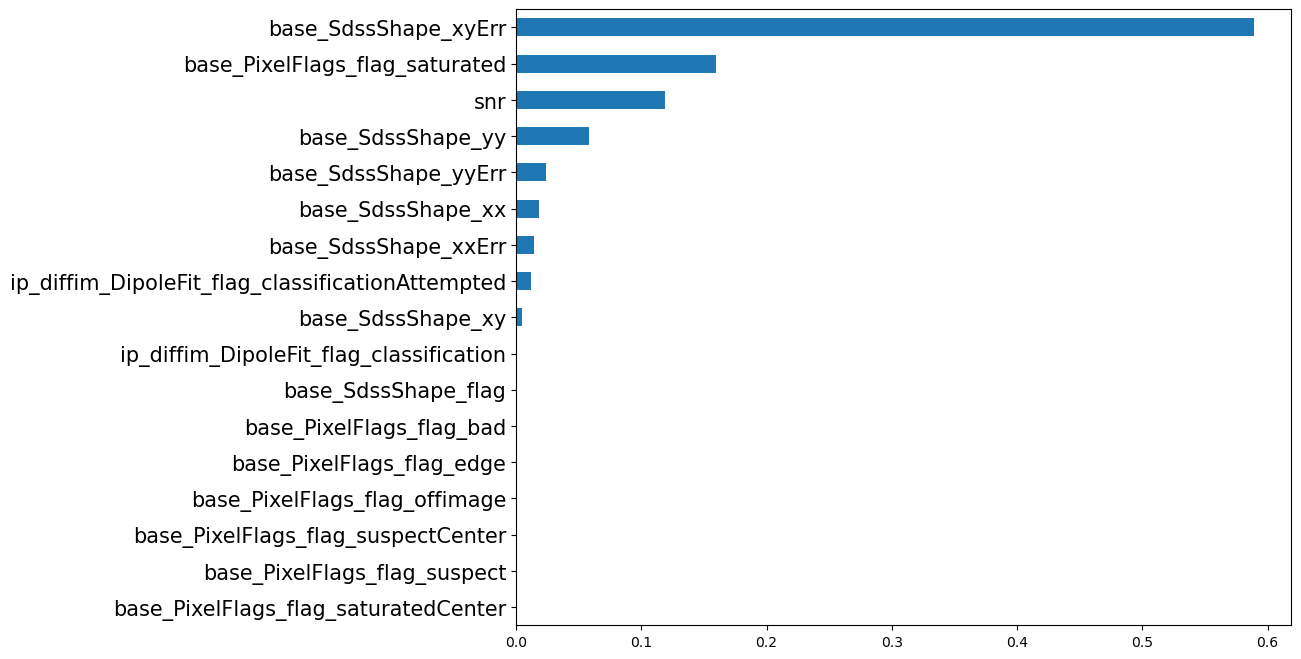

In [31]:
ax = fi.feature_importance.plot(kind='barh', figsize=(10,8))
for label in ax.get_yticklabels():
    label.set_size(15)

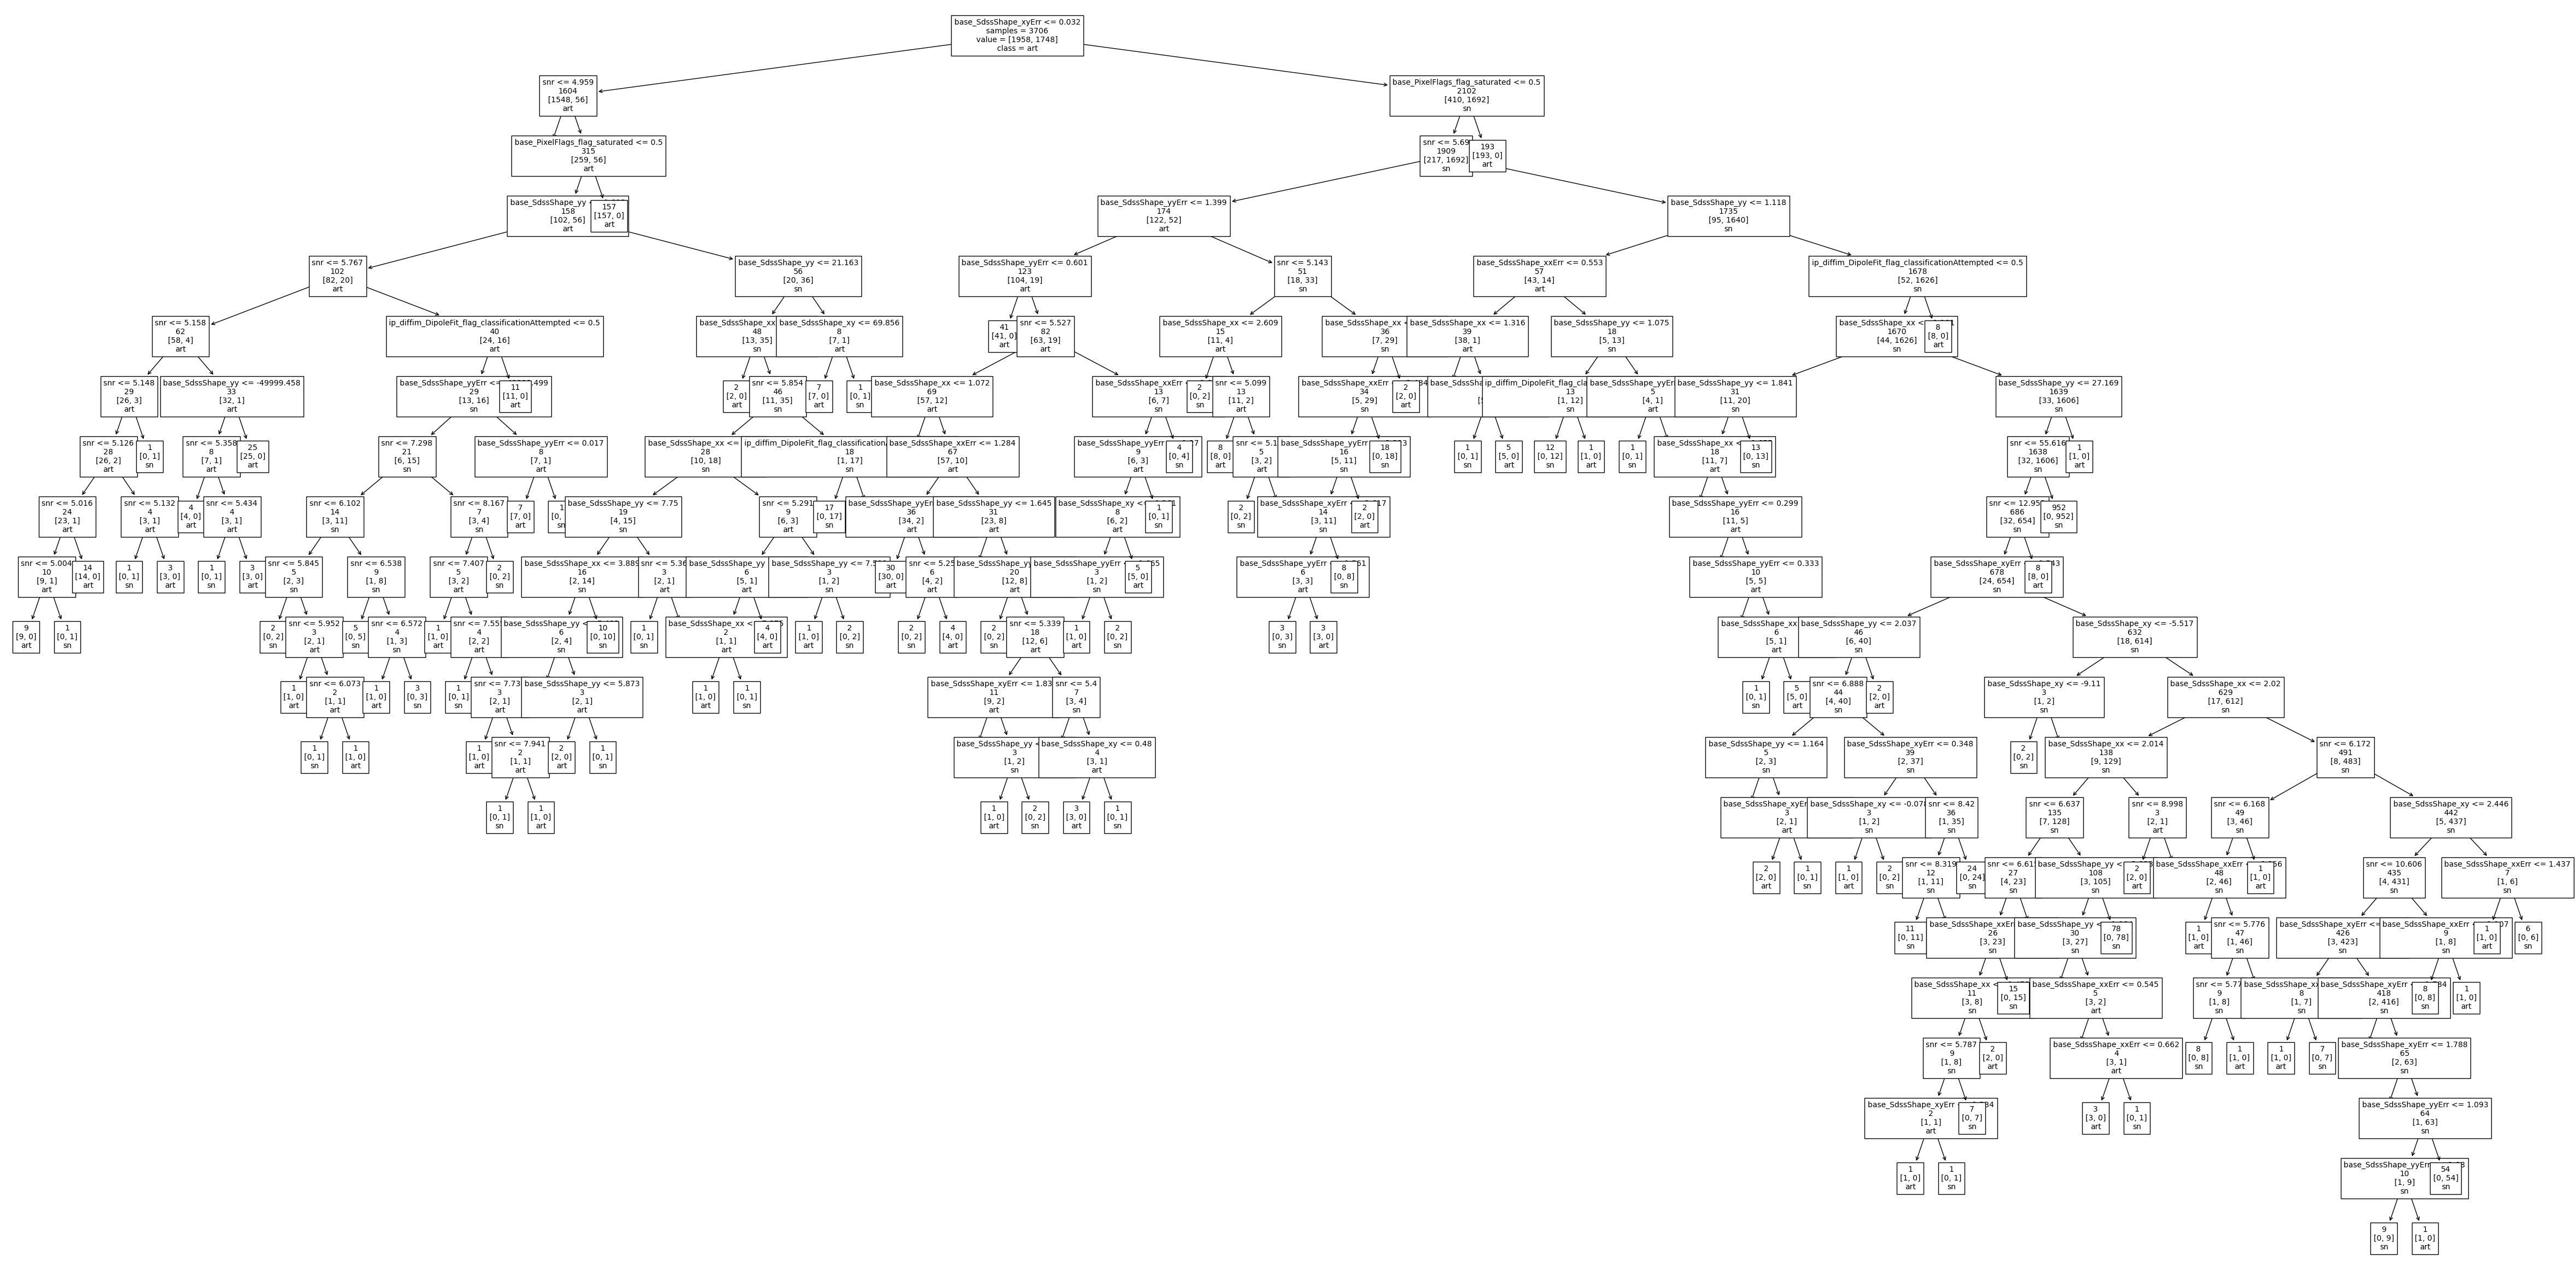

In [72]:
plt.figure(figsize=(60, 30))  # Set a figure size
tree_plot = plot_tree(clf, filled=False, feature_names=list(X_train.columns), class_names=['art', 'sn'], fontsize=10, label='root', impurity=False)
# plt.show()

plt.savefig('tree.png')

In [ ]:


# Sample data
X, y = make_classification(n_samples=1000, n_features=4)

# Classifier
clf = RandomForestClassifier()

# Parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20]
}

# Scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score), 
           'f1': make_scorer(f1_score)}

# Grid search
grid_search = GridSearchCV(clf, param_grid, scoring=scoring, refit=False, cv=5)

# Fit
grid_search.fit(X, y)

# Results
results = grid_search.cv_results_

# You can now analyze the results for each metric
# and select the best model based on your criteria

In [ ]:
selected_cols = ['flags_negative', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge',
                 'base_NaiveCentroid_flag_resetToPeak', 'base_PeakCentroid_flag', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge',
                 'base_SdssCentroid_flag_noSecondDerivative', 'base_SdssCentroid_flag_almostNoSecondDerivative', 'base_SdssCentroid_flag_notAtMaximum',
                 'base_SdssCentroid_flag_resetToPeak', 'base_SdssCentroid_flag_badError', 'ip_diffim_NaiveDipoleCentroid_flag', 'ip_diffim_NaiveDipoleCentroid_pos_flag',
                 'ip_diffim_NaiveDipoleCentroid_neg_flag', 'ip_diffim_NaiveDipoleCentroid_x', 'ip_diffim_NaiveDipoleCentroid_y', 'ip_diffim_NaiveDipoleCentroid_xErr',
                 'ip_diffim_NaiveDipoleCentroid_yErr', 'ip_diffim_NaiveDipoleCentroid_pos_x', 'ip_diffim_NaiveDipoleCentroid_pos_y', 'ip_diffim_NaiveDipoleCentroid_pos_xErr',
                 'ip_diffim_NaiveDipoleCentroid_pos_yErr', 'ip_diffim_NaiveDipoleCentroid_neg_x', 'ip_diffim_NaiveDipoleCentroid_neg_y', 'ip_diffim_NaiveDipoleCentroid_neg_xErr',
                 'ip_diffim_NaiveDipoleCentroid_neg_yErr', 'base_SdssShape_xx', 'base_SdssShape_yy', 'base_SdssShape_xy', 'base_SdssShape_xxErr', 'base_SdssShape_yyErr', 'base_SdssShape_xyErr',

                 'base_SdssShape_instFlux', 'base_SdssShape_instFluxErr', 'base_SdssShape_psf_xx', 
                 'base_SdssShape_psf_yy', 'base_SdssShape_psf_xy', 'base_SdssShape_instFlux_xx_Cov',
                 'base_SdssShape_instFlux_yy_Cov', 'base_SdssShape_instFlux_xy_Cov', 'base_SdssShape_flag', 
                 'base_SdssShape_flag_unweightedBad', 'base_SdssShape_flag_unweighted', 'base_SdssShape_flag_shift',
                 'base_SdssShape_flag_maxIter', 'base_SdssShape_flag_psf',
                 
                 'base_CircularApertureFlux_3_0_instFlux', 'base_CircularApertureFlux_3_0_instFluxErr', 'base_CircularApertureFlux_3_0_flag',
                 'base_CircularApertureFlux_3_0_flag_apertureTruncated', 'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated', 'base_CircularApertureFlux_4_5_instFlux',
                 'base_CircularApertureFlux_4_5_instFluxErr', 'base_CircularApertureFlux_4_5_flag', 'base_CircularApertureFlux_4_5_flag_apertureTruncated',
                 'base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated', 'base_CircularApertureFlux_6_0_instFlux', 'base_CircularApertureFlux_6_0_instFluxErr',
                 'base_CircularApertureFlux_6_0_flag', 'base_CircularApertureFlux_6_0_flag_apertureTruncated', 'base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated',
                 'base_CircularApertureFlux_9_0_instFlux', 'base_CircularApertureFlux_9_0_instFluxErr', 'base_CircularApertureFlux_9_0_flag',
                 'base_CircularApertureFlux_9_0_flag_apertureTruncated', 'base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated',
                 'base_CircularApertureFlux_12_0_instFlux', 'base_CircularApertureFlux_12_0_instFluxErr', 'base_CircularApertureFlux_12_0_flag',
                 'base_CircularApertureFlux_12_0_flag_apertureTruncated', 'base_CircularApertureFlux_17_0_instFlux',
                 'base_CircularApertureFlux_17_0_instFluxErr', 'base_CircularApertureFlux_17_0_flag', 'base_CircularApertureFlux_17_0_flag_apertureTruncated',
                 'base_CircularApertureFlux_25_0_instFlux', 'base_CircularApertureFlux_25_0_instFluxErr', 'base_CircularApertureFlux_25_0_flag',
                 'base_CircularApertureFlux_25_0_flag_apertureTruncated', 'base_CircularApertureFlux_35_0_instFlux', 'base_CircularApertureFlux_35_0_instFluxErr',
                 'base_CircularApertureFlux_35_0_flag', 'base_CircularApertureFlux_35_0_flag_apertureTruncated', 'base_CircularApertureFlux_50_0_instFlux',
                 'base_CircularApertureFlux_50_0_instFluxErr', 'base_CircularApertureFlux_50_0_flag', 'base_CircularApertureFlux_50_0_flag_apertureTruncated',
                 'base_CircularApertureFlux_70_0_instFlux', 'base_CircularApertureFlux_70_0_instFluxErr', 'base_CircularApertureFlux_70_0_flag',
                 'base_CircularApertureFlux_70_0_flag_apertureTruncated', 
                 
                 'base_GaussianFlux_instFlux', 'base_GaussianFlux_instFluxErr',
'base_GaussianFlux_flag',
'base_LocalPhotoCalib_flag',
'base_LocalPhotoCalib',
'base_LocalPhotoCalibErr',
'base_LocalWcs_flag',
'base_LocalWcs_CDMatrix_1_1',
'base_LocalWcs_CDMatrix_1_2',
'base_LocalWcs_CDMatrix_2_1',
'base_LocalWcs_CDMatrix_2_2',
'base_PeakLikelihoodFlux_instFlux',
'base_PeakLikelihoodFlux_instFluxErr',
'base_PeakLikelihoodFlux_flag',
'base_PixelFlags_flag',
'base_PixelFlags_flag_offimage',
'base_PixelFlags_flag_edge',
'base_PixelFlags_flag_interpolated',
'base_PixelFlags_flag_saturated',
'base_PixelFlags_flag_cr',
'base_PixelFlags_flag_bad',
'base_PixelFlags_flag_suspect',
'base_PixelFlags_flag_interpolatedCenter',
'base_PixelFlags_flag_saturatedCenter',
'base_PixelFlags_flag_crCenter',
'base_PixelFlags_flag_suspectCenter',
'base_PsfFlux_instFlux',

'base_PsfFlux_instFluxErr',

'base_PsfFlux_area',

'base_PsfFlux_chi2',

'base_PsfFlux_npixels',

'base_PsfFlux_flag',

'base_PsfFlux_flag_noGoodPixels',

'base_PsfFlux_flag_edge',

'ip_diffim_NaiveDipoleFlux_flag',
'ip_diffim_NaiveDipoleFlux_pos_flag',
'ip_diffim_NaiveDipoleFlux_neg_flag',
'ip_diffim_NaiveDipoleFlux_pos_instFlux',
'ip_diffim_NaiveDipoleFlux_pos_instFluxErr',
'ip_diffim_NaiveDipoleFlux_neg_instFlux',
'ip_diffim_NaiveDipoleFlux_neg_instFluxErr',
'ip_diffim_NaiveDipoleFlux_npos',
'ip_diffim_NaiveDipoleFlux_nneg',
'ip_diffim_PsfDipoleFlux_flag',
'ip_diffim_PsfDipoleFlux_pos_flag',
'ip_diffim_PsfDipoleFlux_neg_flag',
'ip_diffim_PsfDipoleFlux_pos_instFlux',
'ip_diffim_PsfDipoleFlux_pos_instFluxErr',
'ip_diffim_PsfDipoleFlux_neg_instFlux',
'ip_diffim_PsfDipoleFlux_neg_instFluxErr',
'ip_diffim_PsfDipoleFlux_chi2dof',
'ip_diffim_PsfDipoleFlux_pos_centroid_x',
'ip_diffim_PsfDipoleFlux_pos_centroid_y',
'ip_diffim_PsfDipoleFlux_pos_centroid_xErr',
'ip_diffim_PsfDipoleFlux_pos_centroid_yErr',
'ip_diffim_PsfDipoleFlux_neg_centroid_x',
'ip_diffim_PsfDipoleFlux_neg_centroid_y',
'ip_diffim_PsfDipoleFlux_neg_centroid_xErr',
'ip_diffim_PsfDipoleFlux_neg_centroid_yErr',
'ip_diffim_PsfDipoleFlux_centroid_x',
'ip_diffim_PsfDipoleFlux_centroid_y',
'ip_diffim_PsfDipoleFlux_centroid_xErr',
'ip_diffim_PsfDipoleFlux_centroid_yErr',
'ip_diffim_ClassificationDipole_value',
'ip_diffim_ClassificationDipole_flag',
'ip_diffim_DipoleFit_pos_instFlux',
'ip_diffim_DipoleFit_pos_instFluxErr',
'ip_diffim_DipoleFit_pos_centroid_x',
'ip_diffim_DipoleFit_pos_centroid_y',
'ip_diffim_DipoleFit_neg_instFlux',
'ip_diffim_DipoleFit_neg_instFluxErr',
'ip_diffim_DipoleFit_neg_centroid_x',
'ip_diffim_DipoleFit_neg_centroid_y',
'ip_diffim_DipoleFit_centroid_x',
'ip_diffim_DipoleFit_centroid_y',
'ip_diffim_DipoleFit_instFlux',
'ip_diffim_DipoleFit_orientation',
'ip_diffim_DipoleFit_separation',
'ip_diffim_DipoleFit_chi2dof',
'ip_diffim_DipoleFit_signalToNoise',
'ip_diffim_DipoleFit_flag_classification',
'ip_diffim_DipoleFit_flag_classificationAttempted',
'ip_diffim_DipoleFit_flag',
'ip_diffim_DipoleFit_flag_edge',
'base_GaussianFlux_apCorr',
'base_GaussianFlux_apCorrErr',
'base_GaussianFlux_flag_apCorr',
'base_PsfFlux_apCorr',

'base_PsfFlux_apCorrErr',

'base_PsfFlux_flag_apCorr',

'ip_diffim_forced_PsfFlux_instFlux',
'ip_diffim_forced_PsfFlux_instFluxErr',
'ip_diffim_forced_PsfFlux_area',
'ip_diffim_forced_PsfFlux_flag',
'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
'ip_diffim_forced_PsfFlux_flag_edge']
